# Refuse ANN 

### Load and preprocess data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import regularizers


file_path = Path.home() / 'Desktop' / 'Senior-project' / 'Two_Year_Training_Set.csv'
data = pd.read_csv(file_path)
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
wind_data = data[['BeginDate', 'Wood','Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_86580\1161113234.py:10: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wood'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [4]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wood'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [5]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wood'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [6]:
# Large computation 
data['Previous_Year_Wood'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [7]:
cutoff_date = pd.to_datetime("2023-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Wood','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [8]:


usable_data['Previous_Day_Wood'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Wood'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [9]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Year'] = usable_data['BeginDate'].dt.year
usable_data['Month'] = usable_data['BeginDate'].dt.month
features = usable_data[['Previous_Day_Wood','Month','Previous_2Day_Wood','Sum','Hour_of_Day','Previous_Year_Wood','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]


# Useless Features , , 
target = usable_data['Wood']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (93643, 18)
Target shape:  (93643,)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(X_train, y_train, epochs=55, validation_split=0.15, batch_size=128)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 189.0595 - val_loss: 170.1359
Epoch 2/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 156.9916 - val_loss: 101.8709
Epoch 3/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 88.2892 - val_loss: 20.5482
Epoch 4/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.5880 - val_loss: 12.9312
Epoch 5/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.2012 - val_loss: 13.3048
Epoch 6/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.7497 - val_loss: 11.1756
Epoch 7/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.2864 - val_loss: 11.9922
Epoch 8/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.6763 - val_loss: 10.0846
Epoch 9/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.7146 - val_loss: 9.7945
Epoch 10/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.3591 - val_loss: 10.9438
Epoch 11/55
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.2162 - val_loss: 9.5202
Epoch 12/55
498/498 ━━━━━━━━

### Analysis

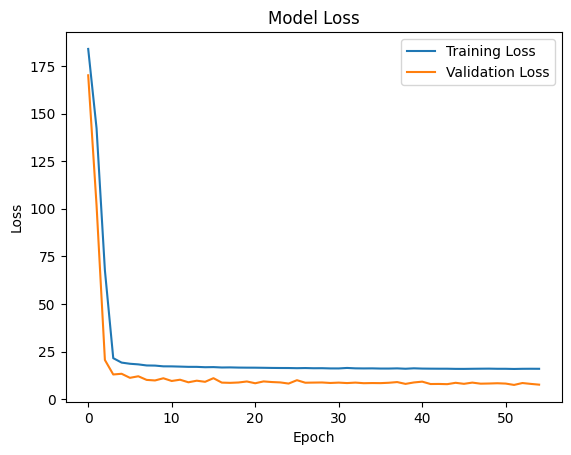

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [16]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


586/586 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predicted Solar Energy Ouput: [272.6867980957031, 228.88743591308594, 219.1302032470703, 200.88987731933594, 166.0273895263672, 301.82647705078125, 298.27471923828125, 128.72804260253906, 214.86776733398438, 108.2772216796875, 197.7024383544922, 211.2561492919922, 79.20735931396484, 61.56938552856445, 261.0228271484375, 254.96670532226562, 106.66413116455078, 254.6154022216797, 21.093585968017578, 233.39707946777344]
Actual Solar Energy Output: [268. 225. 210. 201. 171. 297. 285. 147. 216. 109. 199. 206.  81.  63.
 253. 262. 103. 256.  37. 238.]


In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 7.313135958499513
Mean Squared Error (MSE): 97.41718638707891
Root Mean Squared Error (RMSE): 9.87001450794673
Percent Error (PERR): 0.0378851255238403


### Save model

In [17]:
model.save('WoodModel.h5')